In [1]:
from aemulusnu_massfunction.utils import *
from aemulusnu_massfunction.massfunction import *

import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os
import emcee
import sys
import numpy as np
import pickle

In [2]:
cosmos_f = open('../data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

In [3]:
a_list_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alist.pkl'
a_list_f = open(a_list_fname, 'rb')
a_list = pickle.load(a_list_f) 
a_list_f.close()

###TEMP
# a_list = [a_list[0], a_list[1]]
#######
print('alist', a_list)

alist [1.0, 0.953321, 0.866399, 0.787402, 0.715608, 0.65036, 0.620002, 0.591061, 0.563471, 0.537169, 0.512095, 0.488191, 0.403224, 0.366459, 0.302679]


In [4]:
# a_list = a_list[:-1]

In [5]:
weird_boxes = []
errors = {a:{} for a in a_list}

shots = {a:{} for a in a_list}


for box in tqdm(cosmo_params):
    if(box in weird_boxes):
        continue
    jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
    jackknife_covs_f = open(jackknife_covs_fname, 'rb')
    jackknife = pickle.load(jackknife_covs_f)
    jackknife_covs_f.close()

#     if('n50' in box and eval(box.split('_')[-2])>=45):
#         print('skippinig', box)
#         continue
#     if('n50' in box or eval(box.split('_')[0][3:]) >= 75):
#         print('ski', box)
    for a in a_list:
        plot_data = None
        try:
            with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_NvMemulator_loo_output.pkl"%(box, a), "rb") as f:
                plot_data = pickle.load(f)
        except:
            print('skipiping', box)
            continue
        model = plot_data['tinker_eval']
        true  = plot_data['N']
        edges = plot_data['edges']
        edgeslog10 = np.log10(edges)
        assert(len(true) == len(model))
        assert(len(true) == len(edges)-1)
        jack_error = jackknife[a][1]

        for ledge, redge, model_in_bin, true_in_bin, jk_err in zip(edgeslog10, edgeslog10[1:], model, true, np.diag(jack_error)):
            ledge = np.round(ledge, decimals=1)
            redge = np.round(redge, decimals=1)
            if((ledge, redge) not in errors[a]):
                errors[a][(ledge, redge)] = []
                shots[a][(ledge, redge)] = [] 

            errors[a][(ledge, redge)] += [np.abs(model_in_bin-true_in_bin)/true_in_bin]
            shots[a][(ledge, redge)] += [np.sqrt(jk_err) / true_in_bin]


 32%|███▏      | 48/150 [00:14<00:28,  3.62it/s]

skipiping Box47_1400


100%|██████████| 150/150 [00:26<00:00,  5.60it/s]


In [6]:
plt.show()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

plt.rcParams['font.size'] = 11
# import seaborn as sns

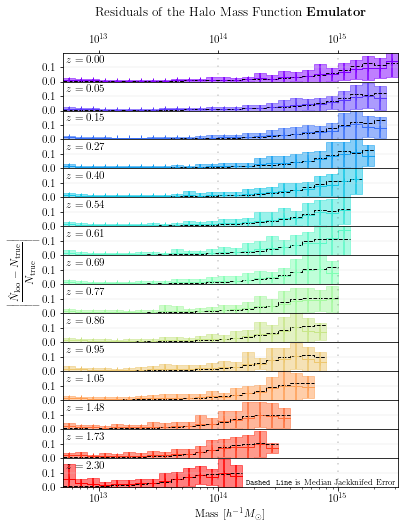

In [7]:
n_a = len(a_list)
fig, axs = plt.subplots(nrows=n_a, ncols=1, figsize=(6,8), sharex=True)
fig.text(0.06, 0.5, r'$$\left|\frac{\hat N_{\rm loo}-N_{\rm true}}{N_{\rm true}} \right|$$'+'\n\n', 
         ha='center', 
         va='center', 
         rotation='vertical',
        fontsize=11)


# big_ax.set_ylabel()


import matplotlib as mpl
import matplotlib.colors as mcolors
rainbow = mpl.colormaps['rainbow'].resampled(n_a)
rainbow_list = [mcolors.rgb2hex(rainbow(i)) for i in range(rainbow.N)]

plt.subplots_adjust(wspace=0, hspace=0)
mn = 1e20
mx = -1

axs[0].set_title(r'Residuals of the Halo Mass Function \textbf{Emulator}' + '\n')
axs[0].tick_params(top=True, labeltop=True)
axs[-1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')

for i, ax in enumerate(axs):
    a = a_list[i]


    edges = []
    y = []
    shot_noise = []
    yerr = []
    for bins in sorted(errors[a]):
        if(bins[1]-bins[0] > 0.15): #ignore adaptive bins
            continue
        if(len(errors[a][bins])<=10): 
            continue
        if(bins[0]< mn):
            mn = bins[0]
        if(bins[1] > mx):
            mx = bins[1]
        if(bins[0] not in edges):
            edges+=[(bins[0])]
        if(bins[1] not in edges):
            edges+=[(bins[1])]
        shot_noise += [np.median(shots[a][bins])]
        y += [np.mean(errors[a][bins])]
        yerr += [np.std(errors[a][bins])]


    edge_centers = [1/2*(a+b) for a,b in zip(edges, edges[1:])]
    edges = 10**np.array(edges)
    edge_centers = 10**np.array(edge_centers)
#     print(edges)
#     print(y)
    ax.step(edges, y+[y[-1]], where='post', linewidth=1, c=rainbow_list[i])

#     ax.bar(x=edges[:-1], width=np.diff(edges),
#           fill=False, height=y, align='edge', ec=rainbow_list[i])
    

    ax.errorbar(x=edge_centers, y=y, yerr = yerr, marker='+', color=rainbow_list[i], ls='none')


    tmp_data = {
        'x': [],
        'y1': [],
        'y2': []}
    bin_idx = 0
    for l,r in zip(edges, edges[1:]):
        tmp_data['x'] += [l,r]
        tmp_data['y1'] += [y[bin_idx]+yerr[bin_idx], y[bin_idx]+yerr[bin_idx]]
        tmp_data['y2'] += [y[bin_idx]-yerr[bin_idx], y[bin_idx]-yerr[bin_idx]]
        bin_idx+=1

    ax.fill_between(**tmp_data,  alpha=.5, color=rainbow_list[i])

#     ax.axvline(1e13, ls=(0,(5,20)),lw=0.3, color='k')
    ax.axvline(1e14, ls=(0,(5,20)),lw=0.3, color='k')
    ax.axvline(1e15, ls=(0,(5,20)),lw=0.3, color='k')

    ax.axhline(0.1, ls='-',lw=0.3, color='lightgrey')
#     ax.axhline(-0.0, ls='-',lw=1, color='grey')

    ax.axhline(-0.1, ls='-',lw=0.3, color='lightgrey')
    ax.step(edges, shot_noise+[shot_noise[-1]], 'k--', where='post', linewidth=1)
#     ax.step(edges, -np.array(shot_noise+[shot_noise[-1]]), 'k--', where='post', linewidth=0.8)

    ax.set_yticks([ -0.1,0, 0.1,])
    ax.text(.01, .9,
        s=r'$z=%.2f$'%(scaleToRedshift(a)),
        transform=ax.transAxes,
        horizontalalignment='left',
        verticalalignment='top',
            c='black',
       fontsize=11)

    ax.set_xscale('log')
    ax.set_ylim([0,0.199])
#     ax.set_ylabel(r'$\frac{N_{\rm Fit}-N_{\rm data}}{N_{\rm data}} $')
axs[-1].text(.995, .01,
        s=r'\texttt{Dashed Line} is Median Jackknifed Error',
        transform=ax.transAxes,
        horizontalalignment='right',
        verticalalignment='bottom',
            c='black',
       fontsize=8)
for ax in axs:
    ax.set_xlim(10**mn, 10**mx)

# plt.savefig('emu_performance_fixed_redshift.pdf')#, bbox_inches='tight')
plt.savefig('emu_performance.pdf', bbox_inches='tight')
